### Photutils + Statmorph -> 星系形态学参数（小图）

1. Photutils 背景去除、分割、解混，得到 mask，image；https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html

2. Statmorph 参数测量。https://statmorph.readthedocs.io/en/latest/

注：以Desi的数据为例，对单波段的参数进行测量。


In [80]:
import numpy as np
from astropy.io import fits
import os
import urllib.request
from astropy.wcs import WCS
import pandas as pd
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel, detect_sources
from statmorph import source_morphology

import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Sersic2D
from astropy.visualization import AsinhStretch, ImageNormalize
from statmorph.utils.image_diagnostics import make_figure

import matplotlib.pyplot as plt

def plot_double_sersic_from_morph(morph, shape=(256, 256)):
    """
    根据 statmorph 的双Sersic拟合结果，可视化两个成分和总模型。
    参数:
    - morph: statmorph.SourceMorphology 对象（包含 doublesersic_* 属性）
    - shape: 图像尺寸 (height, width)，默认 (256, 256)
    - save_path: 可选，保存图像的路径（如 "model_plot.png"）
    """
    # -------------------------------
    # 1. 设置图像尺寸和网格
    # -------------------------------
    y, x = np.mgrid[0:shape[0], 0:shape[1]]
    # -------------------------------
    # 2. 提取双Sersic参数（来自 morph 对象）
    # -------------------------------
    xc = morph.xc_centroid
    yc = morph.yc_centroid
    # 成分 1（核球）
    amplitude1 = morph.doublesersic_amplitude1
    rhalf1 = morph.doublesersic_rhalf1
    n1 = morph.doublesersic_n1
    ellip1 = morph.doublesersic_ellip1
    theta1 = morph.doublesersic_theta1
    # 成分 2（盘）
    amplitude2 = morph.doublesersic_amplitude2
    rhalf2 = morph.doublesersic_rhalf2
    n2 = morph.doublesersic_n2
    ellip2 = morph.doublesersic_ellip2
    theta2 = morph.doublesersic_theta2
    # 计算轴比 b/a
    ba1 = 1 - ellip1
    ba2 = 1 - ellip2
    # -------------------------------
    # 3. 构建 Sersic 模型
    # -------------------------------
    sersic1 = Sersic2D(
        amplitude=amplitude1,
        r_eff=rhalf1,
        n=n1,
        x_0=xc,
        y_0=yc,
        ellip=ellip1,
        theta=theta1
    )
    sersic2 = Sersic2D(
        amplitude=amplitude2,
        r_eff=rhalf2,
        n=n2,
        x_0=xc,
        y_0=yc,
        ellip=ellip2,
        theta=theta2
    )
    model1 = sersic1(x, y)  # 核球
    model2 = sersic2(x, y)  # 盘
    total_model = model1 + model2
    # -------------------------------
    # 4. 绘图
    # -------------------------------
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle("Double Sersic Model Reconstruction", fontsize=16)
    norm = ImageNormalize(vmin=0, stretch=AsinhStretch())
    # Component 1
    im1 = axes[0].imshow(model1, origin='lower', cmap='Blues', norm=norm)
    axes[0].set_title(f'Component 1: n={n1:.2f}, $r_{{1/2}}$={rhalf1:.1f}\n$\\epsilon$={ellip1:.2f}, $b/a$={ba1:.2f}')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    # Component 2
    im2 = axes[1].imshow(model2, origin='lower', cmap='Oranges', norm=norm)
    axes[1].set_title(f'Component 2: n={n2:.2f}, $r_{{1/2}}$={rhalf2:.1f}\n$\\epsilon$={ellip2:.2f}, $b/a$={ba2:.2f}')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    # Total Model
    im3 = axes[2].imshow(total_model, origin='lower', cmap='viridis', norm=norm)
    axes[2].set_title('Total Model (Bulge + Disk)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    # Contour Plot
    levels = np.logspace(np.log10(0.1), np.log10(total_model.max()), 10)
    axes[3].contour(total_model, levels=levels, cmap='Reds', alpha=0.8)
    axes[3].set_aspect('equal')
    axes[3].set_title('Total Model - Contour Plot')
    axes[3].grid(False)
    # 统一设置标签
    for ax in axes.flat:
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_single_sersic_from_morph(morph, shape=(256, 256)):
    """
    根据 statmorph 的单Sersic拟合结果，可视化模型。
    参数:
    - morph: statmorph.SourceMorphology 对象（包含 sersic_* 属性）
    - shape: 图像尺寸 (height, width)，默认 (256, 256)
    - save_path: 可选，保存图像的路径（如 "single_sersic_model.png"）
    """
    y, x = np.mgrid[0:shape[0], 0:shape[1]]
    xc = morph.sersic_xc
    yc = morph.sersic_yc
    amplitude = morph.sersic_amplitude
    rhalf = morph.sersic_rhalf
    n = morph.sersic_n
    ellip = morph.sersic_ellip
    theta = morph.sersic_theta
    ba = 1 - ellip  # 轴比
    sersic_model = Sersic2D(
        amplitude=amplitude,
        r_eff=rhalf,
        n=n,
        x_0=xc,
        y_0=yc,
        ellip=ellip,
        theta=theta
    )
    model = sersic_model(x, y)
    total_model = model  # 单成分
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 少一个子图
    fig.suptitle(f"Single Sersic Model (n={n:.2f})", fontsize=16)
    norm = ImageNormalize(vmin=0, stretch=AsinhStretch())
    # 模型图像
    im1 = axes[0].imshow(model, origin='lower', cmap='viridis', norm=norm)
    axes[0].set_title(f'Sersic Model: n={n:.2f}, $r_{{1/2}}$={rhalf:.1f}\n$\\epsilon$={ellip:.2f}, $b/a$={ba:.2f}')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    # 等高线图
    axes[1].contour(model, cmap='Reds', alpha=0.8)
    axes[1].set_aspect('equal')
    axes[1].set_title('Contour Plot')
    axes[1].grid(False)
    # 径向剖面（沿主轴）
    from scipy.ndimage import map_coordinates
    def get_radial_profile(image, center, theta, r_eff, ellip):
        a, b = r_eff, r_eff * (1 - ellip)
        t = np.linspace(0, 2*np.pi, 100)
        xp = center[0] + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
        yp = center[1] + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
        profile = map_coordinates(image, [yp, xp], order=1)
        return t, profile
    t, profile = get_radial_profile(model, (xc, yc), theta, rhalf, ellip)
    axes[2].plot(t, profile, 'b-', lw=2)
    axes[2].set_title('Radial Profile (at $r_{1/2}$)')
    axes[2].set_xlabel('Angle (rad)')
    axes[2].set_ylabel('Intensity')
    for ax in [axes[0], axes[1]]:
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
    plt.tight_layout()
    plt.show()
    plt.close()


def download_dr10_cutout(ra, dec, save_dir="/home/data/DESI_spec_dr1_healpix/code/desi_spec_tutorials/dr10_cutouts/"):

    """
    下载LS DR10图像切割图像并返回本地文件路径
    ra: 赤经 (degrees)
    dec: 赤纬 (degrees)
    save_dir: 图像保存目录
    返回值: 本地FITS文件路径
    """

    os.makedirs(save_dir, exist_ok=True)
    filename = f"ls-dr10_cutout_ra{ra:.4f}_dec{dec:.4f}.fits"
    local_path = os.path.join(save_dir, filename)
    url = (
        f"http://legacysurvey.org/viewer/fits-cutout"
        f"?ra={ra}&dec={dec}&layer=ls-dr10&pixscale=0.262&bands=grz&size=256"
    )
    if not os.path.exists(local_path):
        print(f"Downloading DR10 cutout to {local_path} ...")
        urllib.request.urlretrieve(url, local_path)
    else:
        print(f"Using cached file: {local_path}")

    return local_path

def load_fits_image(file_path):
    """
    加载FITS图像并返回图像数据（只提取第一个通道）
    file_path: FITS文件路径
    返回值: 图像数据数组
    """
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data
        if image_data.ndim > 2:  
            image_data = image_data[0]  
    return image_data

def PhotUtils_mask(data, bkg_box_size=(50, 50), filter_size=(3, 3), detection_threshold=1.0, kernel_fwhm=3.0, npixels=10,plot=True):
    """
    背景估计、背景去除、源检测并显示结果。

    参数:
    - data: 输入数据数组。
    - bkg_box_size: 背景估计使用的box尺寸，默认(50, 50)。
    - filter_size: 背景过滤器尺寸，默认(3, 3)。
    - detection_threshold: 检测阈值，通常为背景RMS的倍数，默认3.0。
    - kernel_fwhm: 高斯核的FWHM值，默认3.0。
    - npixels: 检测为有效源所需的最小像素数量，默认10。

    返回:
    - mask: 中心对象的mask。
    """
    # 背景估计与去除
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, bkg_box_size, filter_size=filter_size,
                       bkg_estimator=bkg_estimator)
    data_bg = data - bkg.background  

    # 源检测
    threshold = bkg.background + (detection_threshold * bkg.background_rms)
    kernel = make_2dgaussian_kernel(kernel_fwhm, size=5)
    convolved_data = convolve(data_bg, kernel)
    segment_map = detect_sources(convolved_data, threshold, npixels=npixels)

    # 取中心区域的mask
    y_center, x_center = np.array(data_bg.shape) // 2
    index = segment_map.data[y_center, x_center]
    mask = np.where(segment_map.data == index, 1, 0)

    # 显示图像
    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(data, origin='lower', cmap='Greys_r')
        axs[0].set_title('Data')
        axs[1].imshow(data_bg, origin='lower', cmap='Greys_r')
        axs[1].set_title('Background-subtracted Data')
        axs[2].imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
        axs[2].set_title('Segment Map')
        axs[3].imshow(mask, origin='lower', cmap='Greys_r')
        axs[3].set_title('Mask of Central Object')
        plt.show()
        plt.close()

    return mask

def print_mor(morph):
    print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
    print('xc_centroid =', morph.xc_centroid)
    print('yc_centroid =', morph.yc_centroid)
    print('ellipticity_centroid =', morph.ellipticity_centroid)
    print('elongation_centroid =', morph.elongation_centroid)
    print('orientation_centroid =', morph.orientation_centroid)
    print('xc_asymmetry =', morph.xc_asymmetry)
    print('yc_asymmetry =', morph.yc_asymmetry)
    print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
    print('elongation_asymmetry =', morph.elongation_asymmetry)
    print('orientation_asymmetry =', morph.orientation_asymmetry)
    print('rpetro_circ =', morph.rpetro_circ)
    print('rpetro_ellip =', morph.rpetro_ellip)
    print('rhalf_circ =', morph.rhalf_circ)
    print('rhalf_ellip =', morph.rhalf_ellip)
    print('r20 =', morph.r20)
    print('r80 =', morph.r80)
    print('Gini =', morph.gini)
    print('M20 =', morph.m20)
    print('F(G, M20) =', morph.gini_m20_bulge)
    print('S(G, M20) =', morph.gini_m20_merger)
    print('sn_per_pixel =', morph.sn_per_pixel)
    print('C =', morph.concentration)
    print('A =', morph.asymmetry)
    print('S =', morph.smoothness)
    print()
    print('SERSIC MODEL')
    print('sersic_amplitude =', morph.sersic_amplitude)
    print('sersic_rhalf =', morph.sersic_rhalf)
    print('sersic_n =', morph.sersic_n)
    print('sersic_xc =', morph.sersic_xc)
    print('sersic_yc =', morph.sersic_yc)
    print('sersic_ellip =', morph.sersic_ellip)
    print('sersic_theta =', morph.sersic_theta)
    print('sersic_chi2_dof =', morph.sersic_chi2_dof)
    print()
    print('OTHER')
    print('sky_mean =', morph.sky_mean)
    print('sky_median =', morph.sky_median)
    print('sky_sigma =', morph.sky_sigma)
    print('flag =', morph.flag)
    print('flag_sersic =', morph.flag_sersic)

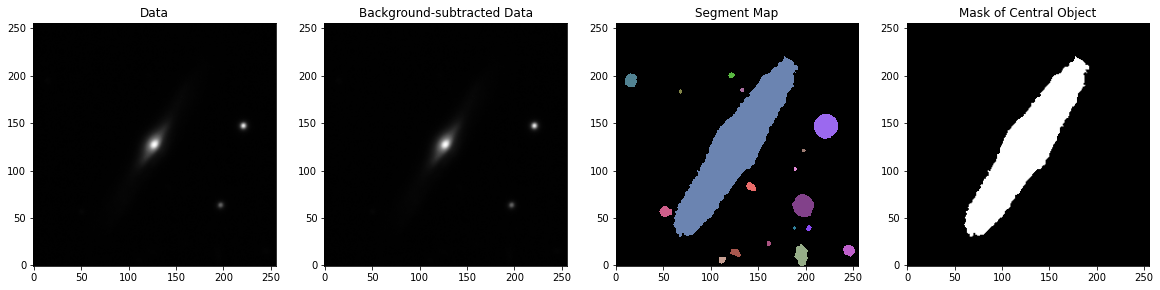

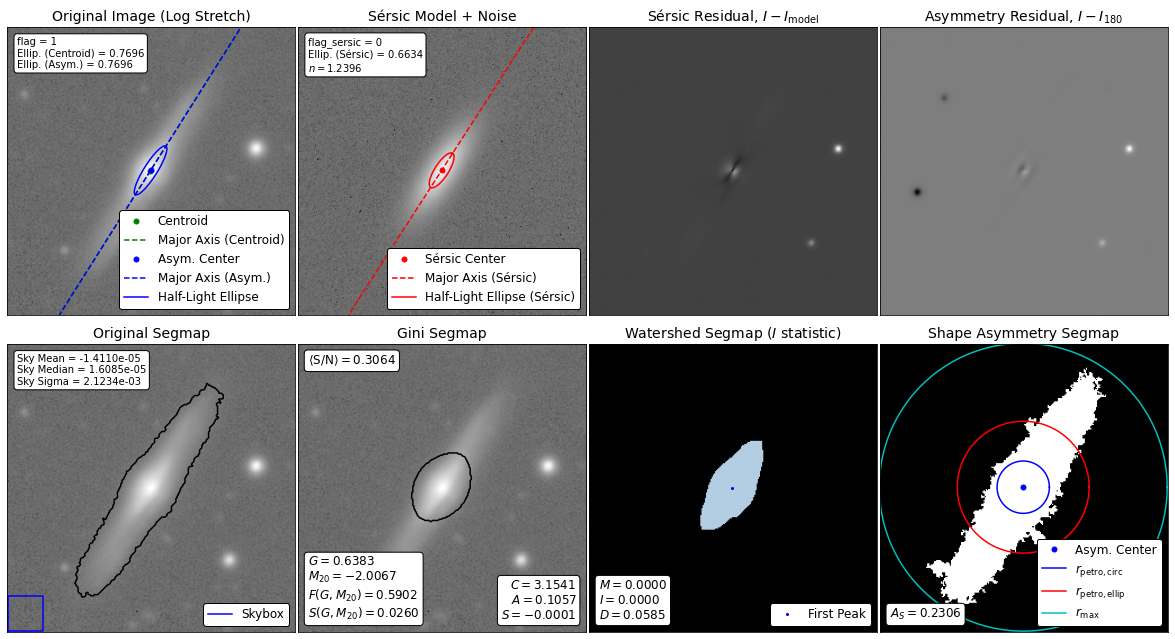

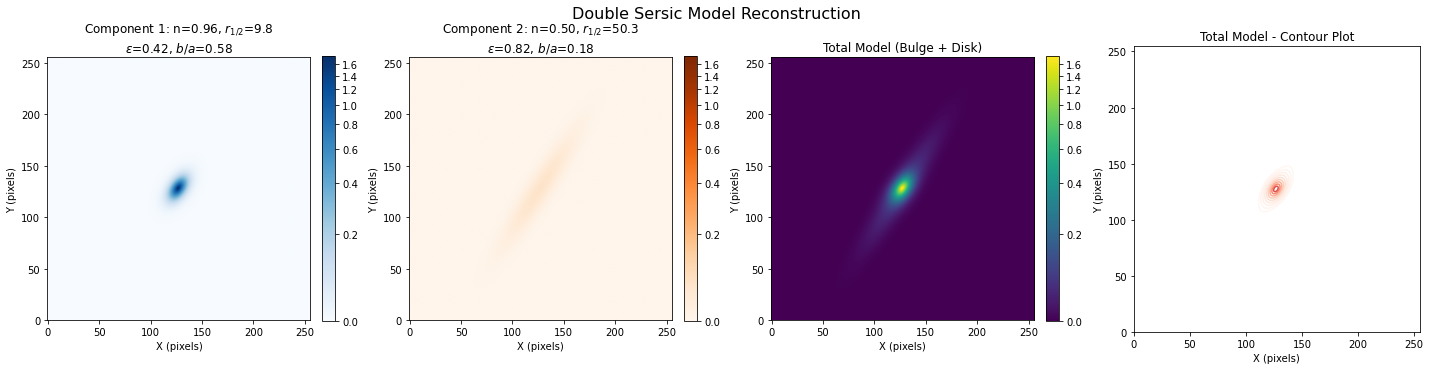

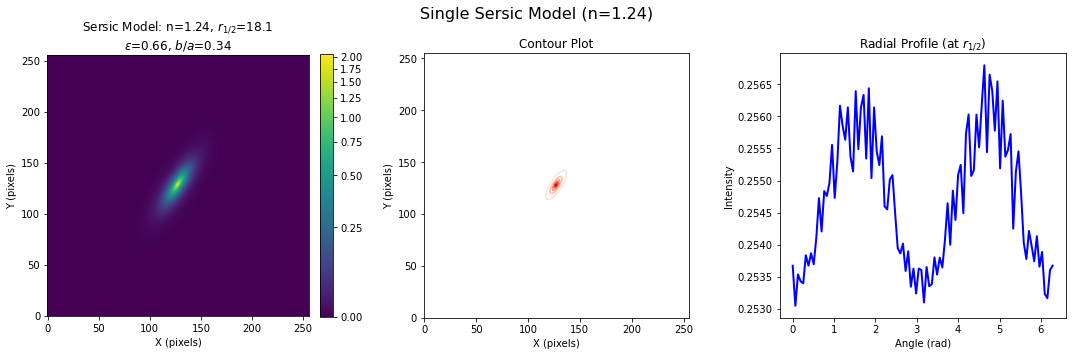

In [81]:
local_path = "/home/data/edgeon.fits"
data = load_fits_image(local_path)

mask = PhotUtils_mask(data)

morph = source_morphology(data, mask, gain=1.0)[0]

fig = make_figure(morph)

plot_double_sersic_from_morph(morph, shape=data.shape)
plot_single_sersic_from_morph(morph, shape=data.shape)

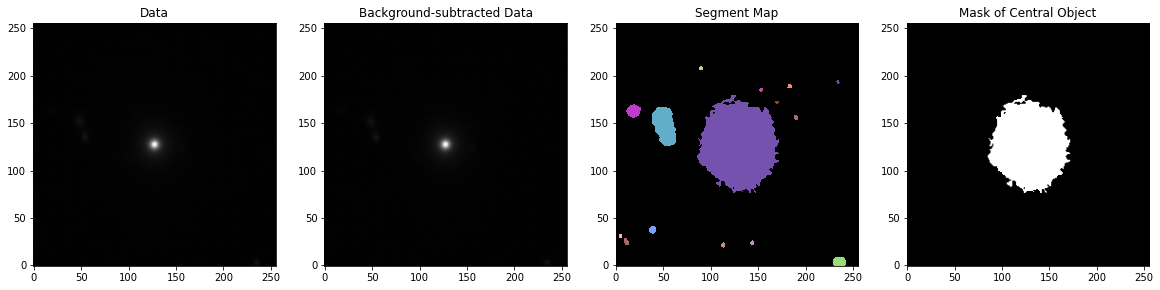

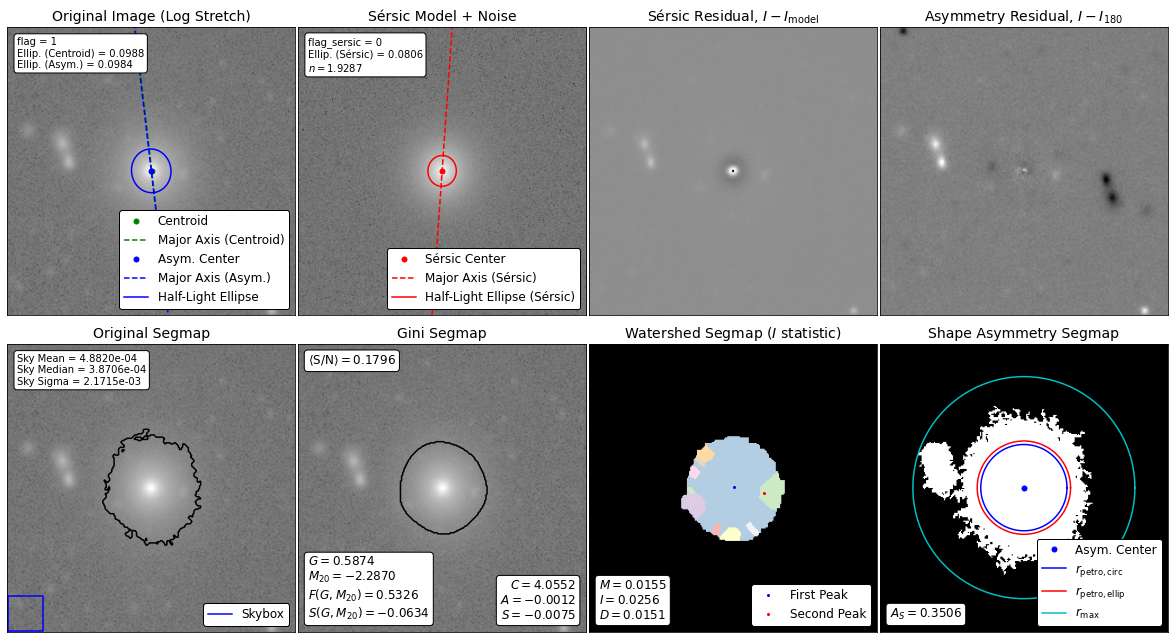

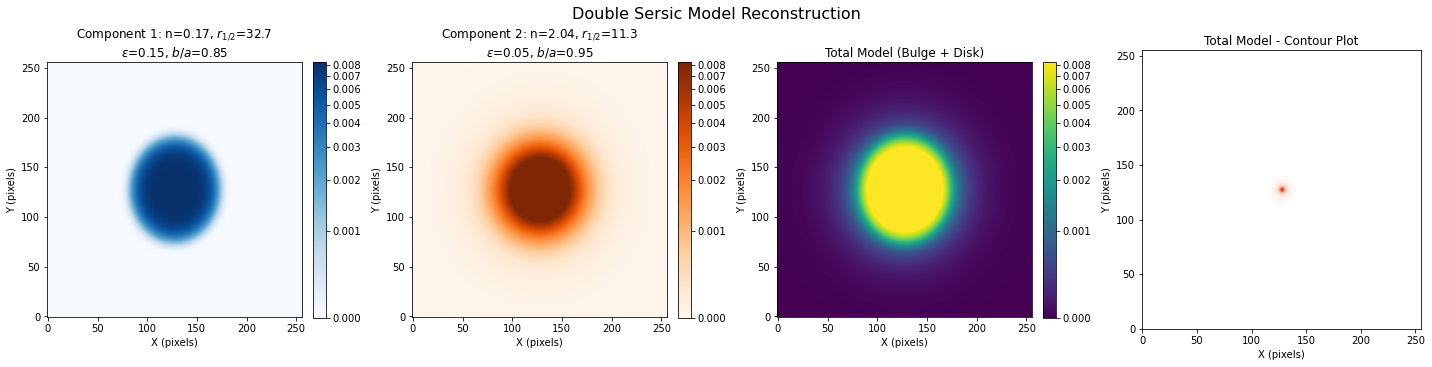

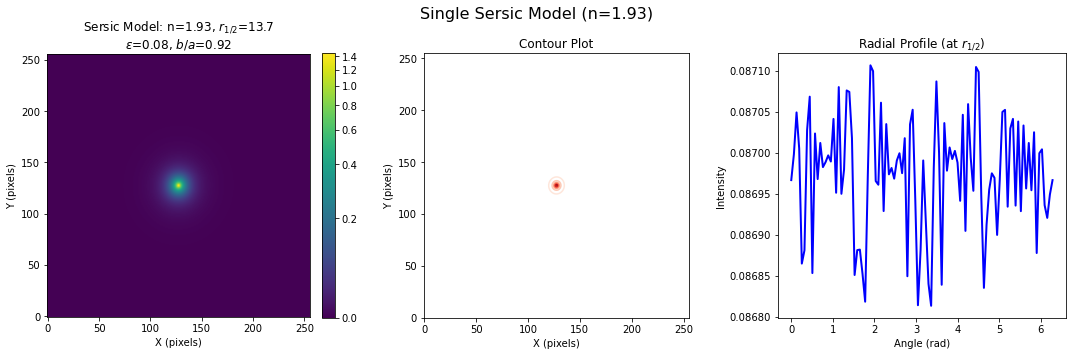

In [82]:
local_path = "/home/data/epilip.fits"
data = load_fits_image(local_path)

mask = PhotUtils_mask(data)

morph = source_morphology(data, mask, gain=1.0)[0]

fig = make_figure(morph)

plot_double_sersic_from_morph(morph, shape=data.shape)
plot_single_sersic_from_morph(morph, shape=data.shape)

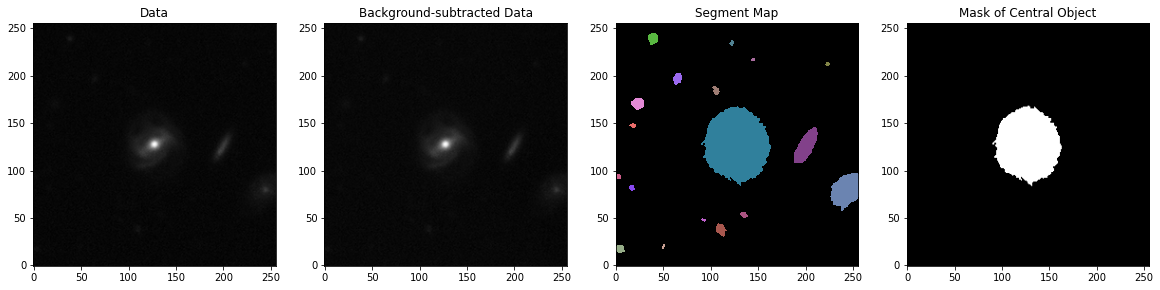

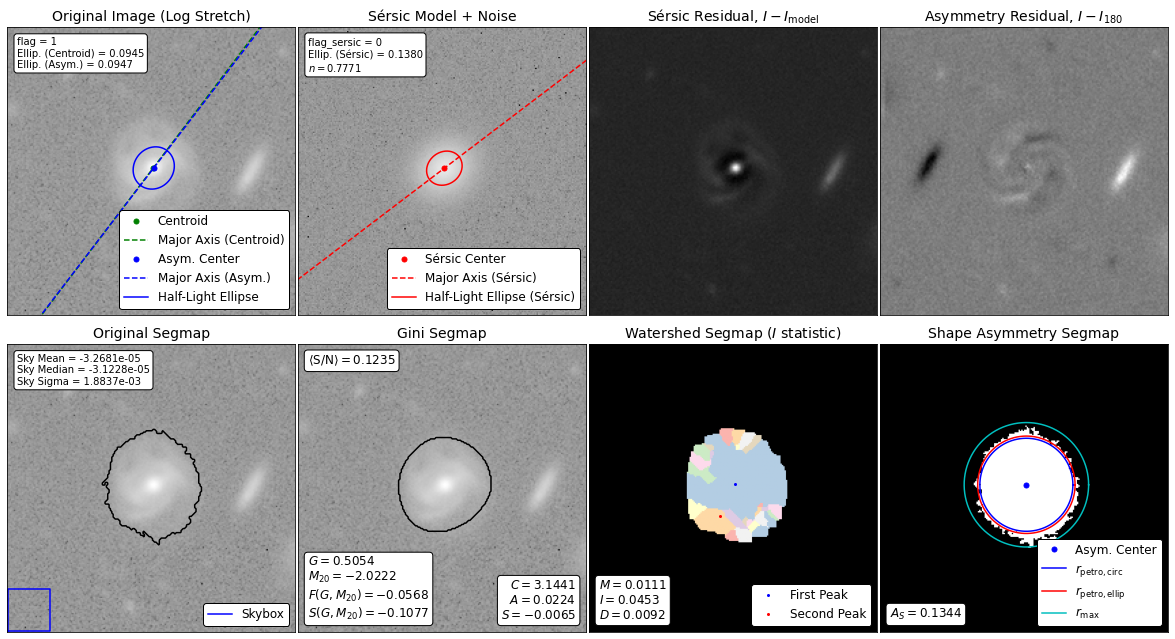

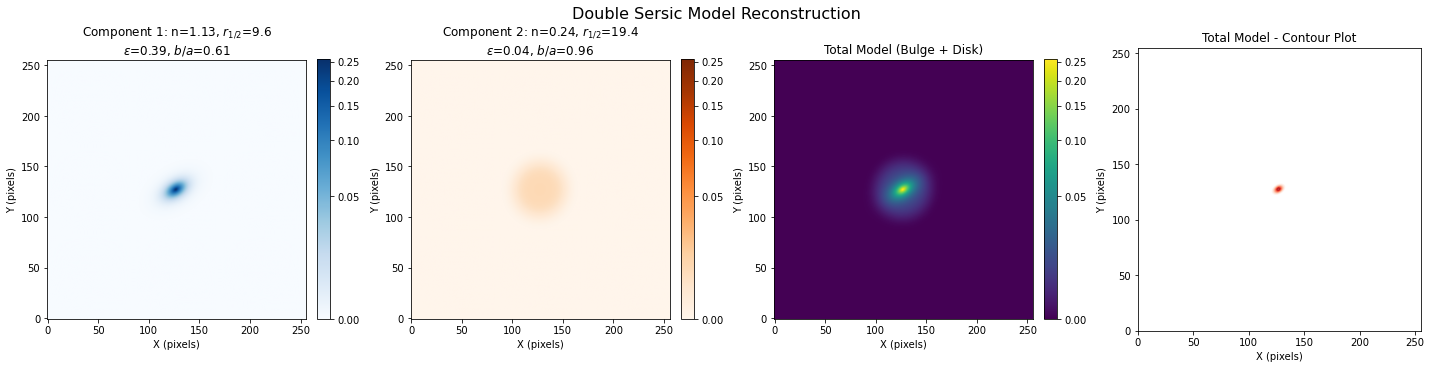

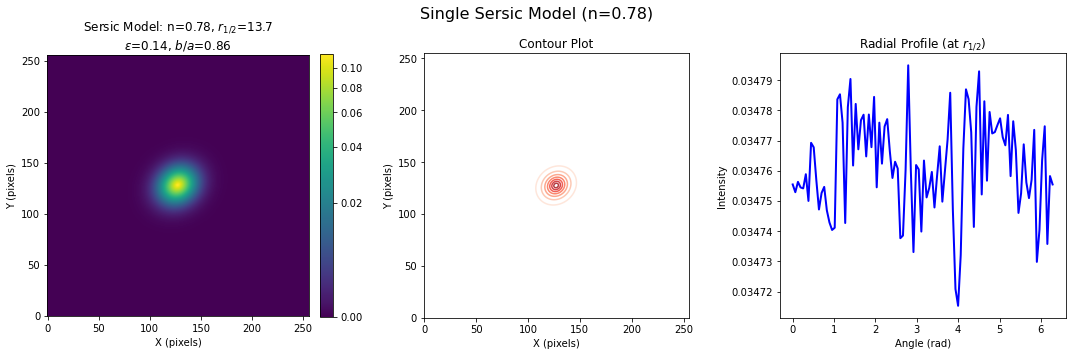

In [83]:
local_path = "/home/data/sprial.fits"
data = load_fits_image(local_path)

mask = PhotUtils_mask(data)

morph = source_morphology(data, mask, gain=1.0)[0]

fig = make_figure(morph)

plot_double_sersic_from_morph(morph, shape=data.shape)
plot_single_sersic_from_morph(morph, shape=data.shape)

In [ ]:
# flag：表示基本形态测量的质量，取以下值之一：0（好）、1（可疑）、2（坏）或 4（灾难性）。更多详细信息可以在这里找到。
# flag_sersic：表示 Sersic 拟合的质量，也采用 0（好）、1（可疑）、2（坏）或 4（灾难性）的值。